# Lithium prescribing trends in England. 

## **Background and Rationale**
For over 60 years lithium has been the gold standard for the treatment and prevention of relapse in bipolar disorder.  In recent years, published literature has confirmed the superiority of lithium in this field, including two meta-analysis of RCTs (Severus et al. 2014, Miura et al. 2014) and one of observational studies (Kessing et al 2018).  Yet in various countries, authors have described a decline in lithium use (Karanti et al. 2016), including in the UK (Hayes et al. 2011, Lyall et al. 2019).  We wish to use NHS prescription data to describe long term lithium prescribing trends in England.  

In 2016, NICE recommended that lithium be used first line in the prevention of relapse in bipolar disorder.  We aim to explore if this recommendation changed prescribing practice.  Furthermore, we would like to see if there are national variations in the use of lithium, as previous authors have suggested (POMH Lithium report, 2008). 

## **Proposed project**
### Title:  
Lithium prescribing trends
### Description:  
* Total number of items of lithium dispensed each year from 1998 to 2018
* Total number of lithium items per 1000 patient population for each CCG with comparison of 2015 data to 2018 data.
* Total number of hospital prescriptions for lithium dispensed at sample timepoints
* Total number of lithium patients registered in GPs as determined by QOF data
* Total number of DDDs of lithium dispensed each year from 2010 to 2019 



In [4]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from matplotlib.dates import DateFormatter
from ebmdatalab import bq
from ebmdatalab import charts
from ebmdatalab import maps
import matplotlib.gridspec as gridspec

### Print graph of lithium use from 1998 to 2018 using PCA data

In [5]:
sql = """
SELECT
drug_name,
Chemical_code_current,
year,
items

FROM ebmdatalab.helen.trends_from_pca_final_2018new

WHERE (Chemical_code_current = "0402030K0" OR Chemical_code_current = "0402030P0")

GROUP BY
year,
drug_name,
Chemical_code_current,
items

ORDER BY
year


"""

df_lithium_pca = bq.cached_read(sql, csv_path = 'lithium_pca.csv')

In [6]:
df_lithium_pca.head(21)

,drug_name,Chemical_code_current,year,items
0,Lithium Carb_Tab Slow 400mg,0402030K0,1998,100.0
1,Camcolit 250_Tab 250mg,0402030K0,1998,42300.0
2,Camcolit 400_Tab 400mg,0402030K0,1998,32600.0
3,Liskonum_Tab 450mg,0402030K0,1998,7800.0
4,Priadel_Tab 400mg,0402030K0,1998,396700.0
5,Priadel 200_Tab 200mg,0402030K0,1998,180000.0
6,Lithonate_Tab 400mg,0402030K0,1998,5700.0
7,Litarex_Tab 564mg,0402030P0,1998,2700.0
8,Priadel_Liq 520mg/5ml S/F,0402030P0,1998,8300.0
9,Li-Liquid_Syr 10.8mmol/5ml,0402030P0,1998,600.0


In [7]:
df_lithium_pca_totalcount = df_lithium_pca.groupby(['year'], as_index=False).sum()
df_lithium_pca_totalcount.head(21)

,year,items
0,1998,677500.0
1,1999,694500.0
2,2000,714495.0
3,2001,738647.0
4,2002,752838.0
5,2003,765062.0
6,2004,780240.0
7,2005,786166.0
8,2006,793642.0
9,2007,810086.0


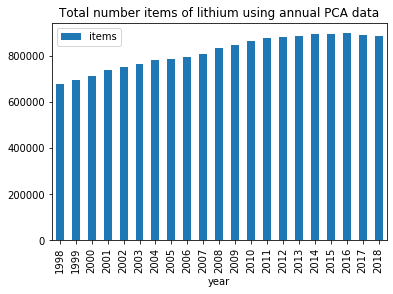

In [8]:
plot1 = df_lithium_pca.groupby("year").sum().plot(kind='bar', title="Total number items of lithium using annual PCA data")


## Describe total lithium dispensed using monthly practice level data from 2010 to 2019

In [9]:
sql2 = """
WITH
bnf_tab AS (
SELECT
DISTINCT chemical,
chemical_code
FROM
ebmdatalab.hscic.bnf )
SELECT
rx.month,
rx.practice,
rx.pct,
SUBSTR(rx.bnf_code,1,9) AS chemical_code,
chemical,
sum(IF(rx.bnf_code LIKE "0402030K0%", items,0)) AS carbonate,
sum(IF(rx.bnf_code LIKE "0402030P0%", items,0)) AS citrate,
sum(items) AS total_lithium,
sum(actual_cost) AS total_cost
FROM
hscic.normalised_prescribing_standard AS rx
LEFT JOIN
bnf_tab
ON
chemical_code =SUBSTR(rx.bnf_code,1,9)
JOIN
hscic.practices AS prac
ON
rx.practice = prac.code 
JOIN
  hscic.ccgs AS ccgs
ON
rx.pct=ccgs.code
WHERE
  prac.setting = 4
  AND (bnf_code LIKE "0402030K0%" OR ##carbonate
  bnf_code LIKE "0402030P0%") ##citrate
  AND
ccgs.org_type='CCG'
GROUP BY
rx.month,
rx.practice,
rx.pct,
chemical_code,
chemical
ORDER BY
month"""

df_lithium = bq.cached_read(sql2, csv_path='lithium.csv')

In [10]:
df_lithium['month'] = df_lithium['month'].astype('datetime64[ns]')
df_lithium.head()

,month,practice,pct,chemical_code,chemical,carbonate,citrate,total_lithium,total_cost
0,2010-08-01,H81019,09Y,0402030K0,Lithium Carbonate,7,0,7,27.23
1,2010-08-01,G81029,09F,0402030K0,Lithium Carbonate,25,0,25,46.04
2,2010-08-01,B81077,03H,0402030K0,Lithium Carbonate,5,0,5,7.97
3,2010-08-01,F85063,08D,0402030K0,Lithium Carbonate,12,0,12,40.90
4,2010-08-01,H85053,08T,0402030K0,Lithium Carbonate,8,0,8,2.73


In [11]:
df_lithium["chemical"].unique()#shows me the unique values within the chemical column

array(['Lithium Carbonate', 'Lithium Citrate'], dtype=object)

In [12]:
df_lithium.nunique()#counts the number of unique items in each column.  

month               110
practice           8022
pct                 191
chemical_code         2
chemical              2
carbonate           136
citrate              35
total_lithium       135
total_cost       190699
dtype: int64

In [13]:
df_carbonate = df_lithium.loc[df_lithium["chemical"] == "Lithium Carbonate"]
df_carbonate.head()#shows me the data for Lithium Carbonate

,month,practice,pct,chemical_code,chemical,carbonate,citrate,total_lithium,total_cost
0,2010-08-01,H81019,09Y,0402030K0,Lithium Carbonate,7,0,7,27.23
1,2010-08-01,G81029,09F,0402030K0,Lithium Carbonate,25,0,25,46.04
2,2010-08-01,B81077,03H,0402030K0,Lithium Carbonate,5,0,5,7.97
3,2010-08-01,F85063,08D,0402030K0,Lithium Carbonate,12,0,12,40.90
4,2010-08-01,H85053,08T,0402030K0,Lithium Carbonate,8,0,8,2.73


In [14]:
df_citrate = df_lithium.loc[df_lithium["chemical"] == "Lithium Citrate"]
df_citrate.head()#shows me the data for Lithium Citrate

,month,practice,pct,chemical_code,chemical,carbonate,citrate,total_lithium,total_cost
79,2010-08-01,C84605,04N,0402030P0,Lithium Citrate,0,1,1,5.36
90,2010-08-01,P81103,01E,0402030P0,Lithium Citrate,0,2,2,26.39
100,2010-08-01,G83001,08A,0402030P0,Lithium Citrate,0,1,1,42.66
111,2010-08-01,C88079,03N,0402030P0,Lithium Citrate,0,1,1,10.36
127,2010-08-01,N81046,02F,0402030P0,Lithium Citrate,0,2,2,44.80


In [15]:
ccg_lithium_totalcount = df_lithium.groupby(["month", "pct"], as_index=False).sum()
ccg_lithium_totalcount.tail()#shows me the data grouped by PCT, therefore representing CCGs

,month,pct,carbonate,citrate,total_lithium,total_cost
21005,2019-09-01,99H,364,2,366,1083.79398
21006,2019-09-01,99J,600,3,603,1216.91034
21007,2019-09-01,99K,221,5,226,530.90471
21008,2019-09-01,99M,234,1,235,783.96083
21009,2019-09-01,99N,668,8,676,1346.09597


In [16]:
ccg_lithium_totalcount.describe()

,carbonate,citrate,total_lithium,total_cost
count,21010.000000,21010.000000,21010.000000,21010.000000
mean,375.297668,3.816564,379.114231,691.242443
std,300.596623,4.707237,304.017283,600.048727
min,27.000000,0.000000,27.000000,49.340000
25%,201.000000,1.000000,203.000000,337.285000
50%,290.000000,2.000000,293.000000,509.399650
75%,446.000000,5.000000,450.000000,822.431118
max,2147.000000,54.000000,2167.000000,5321.818920


### Display total no. of items dispensed per year

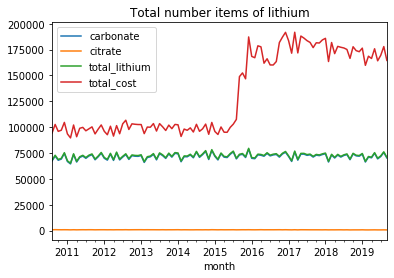

In [17]:
plot2 = df_lithium.groupby("month").sum().plot(kind='line', title="Total number items of lithium")

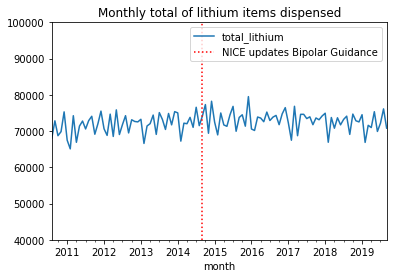

In [18]:
plot3 = df_lithium.groupby("month")['total_lithium'].sum().plot(kind='line', title="Monthly total of lithium items dispensed")
plt.ylim(40000, 100000) #shows just the item count. Increase in cost above due to increased cost of 250mg tablets in 2015/6

#add in timeline to show date of NICE publication of Bipolar guidance.
plot3.axvline('2014-09-01',color='r',linestyle=':', label='NICE updates Bipolar Guidance')
plot3.legend()

In [19]:
## Check data by testing if annual sum of monthly practice level data is similar to annual PCA numbers
## 2011 data  
mask1 = (df_lithium['month'] >= "2011-01-01") & (df_lithium['month'] <= "2011-12-31")
df_annual2011 = df_lithium.loc[mask1]
df_annual2011.sum()

carbonate         843084.00
citrate             8975.00
total_lithium     852059.00
total_cost       1163009.88
dtype: float64

In [17]:
## 2012 data
mask2 = (df_lithium['month'] >= "2012-01-01") & (df_lithium['month'] <= "2012-12-31")
df_annual2012 = df_lithium.loc[mask2]
df_annual2012.sum()

carbonate         852271.00
citrate             9102.00
total_lithium     861373.00
total_cost       1191985.08
dtype: float64

In [18]:
## 2013 data
mask3 = (df_lithium['month'] >= "2013-01-01") & (df_lithium['month'] <= "2013-12-31")
df_annual2013 = df_lithium.loc[mask3]
df_annual2013.sum()

carbonate         858394.0
citrate             9123.0
total_lithium     867517.0
total_cost       1199330.7
dtype: float64

In [19]:
## 2014 data
mask4 = (df_lithium['month'] >= "2014-01-01") & (df_lithium['month'] <= "2014-12-31")
df_annual2014 = df_lithium.loc[mask4]
df_annual2014.sum()

carbonate         869562.00
citrate             8809.00
total_lithium     878371.00
total_cost       1180384.94
dtype: float64

In [20]:
## 2015 data
mask5 = (df_lithium['month'] >= "2015-01-01") & (df_lithium['month'] <= "2015-12-31")
df_annual2015 = df_lithium.loc[mask5]
df_annual2015.sum()

carbonate         870857.00
citrate             8934.00
total_lithium     879791.00
total_cost       1424320.74
dtype: float64

In [21]:
## 2016 data
mask6 = (df_lithium['month'] >= "2016-01-01") & (df_lithium['month'] <= "2016-12-31")
df_annual2016 = df_lithium.loc[mask6]
df_annual2016.sum()

carbonate         871064.00
citrate             9037.00
total_lithium     880101.00
total_cost       2063903.53
dtype: float64

In [22]:
## 2017 data
mask7 = (df_lithium['month'] >= "2017-01-01") & (df_lithium['month'] <= "2017-12-31")
df_annual2017 = df_lithium.loc[mask7]
df_annual2017.sum()

carbonate        8.660520e+05
citrate          8.574000e+03
total_lithium    8.746260e+05
total_cost       2.182405e+06
dtype: float64

### Describe no. of lithium items per 1000 patients in each CCG to show Geographical Variation

In [39]:
##get list size info.  removed pct_id AS pct and AVG(total_list_size) AS list_size
sql3 = """
SELECT month, 
practice, 
total_list_size

FROM ebmdatalab.hscic.practice_statistics_all_years

GROUP BY 
month, practice, total_list_size

ORDER BY
month, practice,
total_list_size
"""
df_list = bq.cached_read(sql3, csv_path='df_list.csv')
df_list['month'] = df_list['month'].astype('datetime64[ns]')
df_list.head(-20)

Downloading: 100%|██████████| 954384/954384 [00:39<00:00, 24338.40rows/s]


,month,practice,total_list_size
0,2010-10-01,A81001,4241
1,2010-10-01,A81002,20535
2,2010-10-01,A81003,3706
3,2010-10-01,A81004,8096
4,2010-10-01,A81005,7970
...,...,...,...
954359,2019-11-01,Y05318,6121
954360,2019-11-01,Y05330,3252
954361,2019-11-01,Y05346,3496
954362,2019-11-01,Y05349,4695


In [40]:
#df_list.isnull().sum()#shows if we are missing data where PCT name is recorded as NaN


In [42]:
ccg_lithium_count = df_lithium.groupby(["month", "practice", "pct"])["total_lithium"].sum().reset_index()
ccg_lithium_count.head(-20)

,month,practice,pct,total_lithium
0,2010-08-01,A81001,00K,6
1,2010-08-01,A81002,00K,20
2,2010-08-01,A81004,00M,10
3,2010-08-01,A81005,00M,14
4,2010-08-01,A81006,00K,28
...,...,...,...,...
752034,2019-09-01,Y04977,15M,2
752035,2019-09-01,Y04995,15M,36
752036,2019-09-01,Y05023,06Q,6
752037,2019-09-01,Y05080,08E,1


In [56]:
#merge dataframes to show items per 1000

df_lithium_per1000 = pd.merge(ccg_lithium_count, df_list, on=['month', 'practice'])
df_lithium_per1000['items_per_1000'] = round(1000* (df_lithium_per1000['total_lithium']/df_lithium_per1000['total_list_size']),2)
df_lithium_per1000.head(-20)

,month,practice,pct,total_lithium,total_list_size,items_per_1000
0,2010-10-01,A81001,00K,7,4241,1.65
1,2010-10-01,A81002,00K,21,20535,1.02
2,2010-10-01,A81004,00M,11,8096,1.36
3,2010-10-01,A81005,00M,15,7970,1.88
4,2010-10-01,A81006,00K,23,12309,1.87
...,...,...,...,...,...,...
737238,2019-09-01,Y04969,05H,3,4487,0.67
737239,2019-09-01,Y04977,15M,2,4972,0.40
737240,2019-09-01,Y04995,15M,36,20014,1.80
737241,2019-09-01,Y05023,06Q,6,3884,1.54


In [59]:
df_lithium_per1000.groupby("month", "pct").sum()

ValueError: No axis named pct for object type <class 'pandas.core.frame.DataFrame'>

In [24]:
#df_lithium_per1000.isnull().any()

month             False
pct               False
carbonate         False
citrate           False
total_lithium     False
total_cost        False
list_size         False
items_per_1000    False
dtype: bool

In [25]:
df_lithium_per1000['month'] = df_lithium_per1000['month'].astype('datetime64[ns]')

In [26]:
df_lithium_per1000.describe()

,carbonate,citrate,total_lithium,total_cost,list_size,items_per_1000
count,19752.000000,19752.000000,19752.000000,19752.000000,19752.000000,19752.000000
mean,339.471345,3.346750,342.818094,638.246262,7235.278324,49.762252
std,226.527323,3.711988,228.740411,503.543235,1965.154499,33.759912
min,27.000000,0.000000,27.000000,56.190000,3543.162162,3.000000
25%,196.000000,1.000000,198.000000,331.580000,5791.465378,29.000000
50%,282.000000,2.000000,285.000000,493.260000,6941.470588,44.000000
75%,418.000000,5.000000,422.000000,774.804685,8508.263636,60.250000
max,1996.000000,45.000000,2007.000000,4827.678090,16296.600000,316.000000


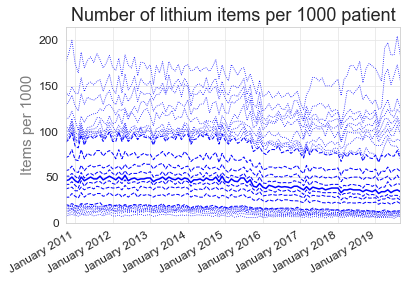

In [27]:
#create sample deciles

charts.deciles_chart(
        df_lithium_per1000,
        period_column='month',
        column='items_per_1000',
        title="Number of lithium items per 1000 patient",
        ylabel='Items per 1000',
        show_outer_percentiles=True,
        show_legend=False,
)

plt.show()

In [32]:
##Restrict to one month to create a map - January 2019
df_lithium_inJan19 = df_lithium_per1000.loc[(df_lithium_per1000['month'] == '2019-01-01')]
df_lithium_inJan19.head()

,month,pct,carbonate,citrate,total_lithium,total_cost,list_size,items_per_1000
18039,2019-01-01,00C,346,0,346,349.49921,9875.000000,35.0
18040,2019-01-01,00D,572,7,579,773.19874,7911.189189,73.0
18041,2019-01-01,00J,486,0,486,713.99498,8748.966667,56.0
18042,2019-01-01,00K,266,3,269,894.21117,9036.939394,30.0
18043,2019-01-01,00L,761,2,763,2877.72280,7774.619048,98.0


In [33]:
df_lithium_inJan19.loc[df_lithium_inJan19['pct']=='99P']

,month,pct,carbonate,citrate,total_lithium,total_cost,list_size,items_per_1000


In [34]:
##Restrict to one month to create a map - Apr2019
df_lithium_inApr19 = df_lithium_per1000.loc[(df_lithium_per1000['month'] == '2019-04-01')]
df_lithium_inApr19.head()

,month,pct,carbonate,citrate,total_lithium,total_cost,list_size,items_per_1000
18606,2019-04-01,00C,306,0,306,344.30782,9885.636364,31.0
18607,2019-04-01,00D,578,3,581,764.98671,8135.222222,71.0
18608,2019-04-01,00J,458,1,459,930.60262,8733.766667,53.0
18609,2019-04-01,00K,246,1,247,882.73490,9051.666667,27.0
18610,2019-04-01,00L,705,6,711,2452.75495,7783.666667,91.0


In [35]:
df_lithium_inApr19.loc[df_lithium_inApr19['pct']=='15N']

,month,pct,carbonate,citrate,total_lithium,total_cost,list_size,items_per_1000
18785,2019-04-01,15N,1847,11,1858,3528.26527,9442.175573,197.0


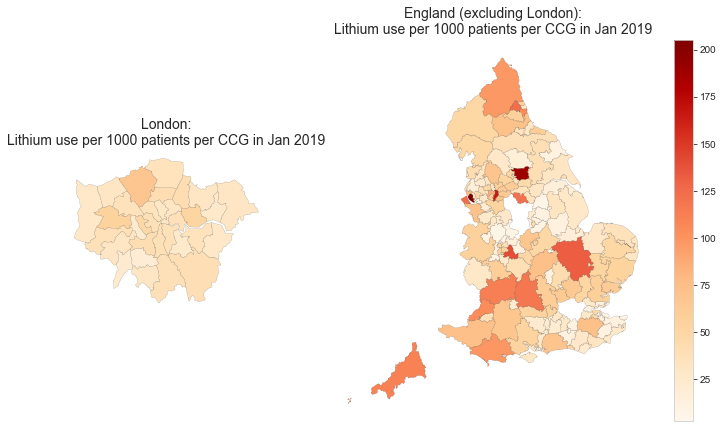

In [36]:
#create choropeth map showing recent prescribing variation (Jan 2019)
plt.figure(figsize=(12, 7))
plt = maps.ccg_map(df_lithium_inJan19, title="Lithium use per 1000 patients per CCG in Jan 2019", map_year='2020', column='items_per_1000', separate_london=True)
plt.show()

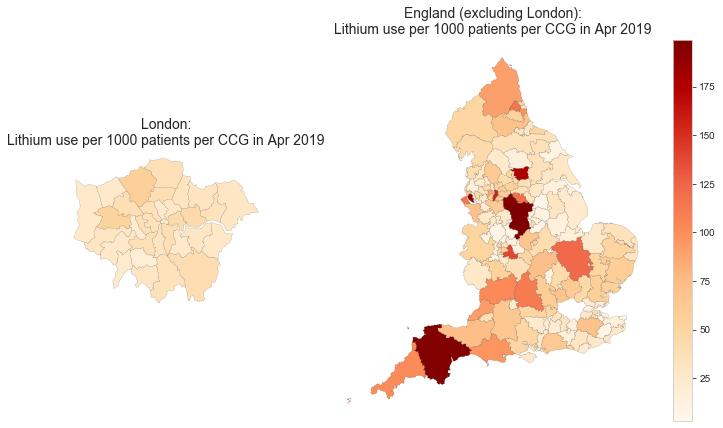

In [37]:
#create choropeth map showing recent prescribing variation (Apr 2019)
plt.figure(figsize=(12, 7))
plt = maps.ccg_map(df_lithium_inApr19, title="Lithium use per 1000 patients per CCG in Apr 2019", map_year='2020', column='items_per_1000', separate_london=True)
plt.show()

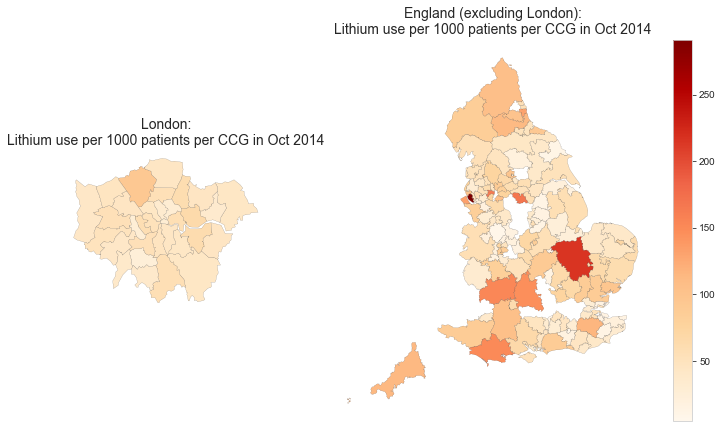

In [34]:
#create choreopath map showing CCG prescribing variation just after NICE publication (Oct2014)
#suggested not to use this as choreopeth maps don't work for 2014 data.
#df_lithium_inOct14 = df_lithium_per1000.loc[(df_lithium_per1000['month'] == '2014-10-01')]
#plt.figure(figsize=(12, 7))
#plt = maps.ccg_map(df_lithium_inOct14, title="Lithium use per 1000 patients per CCG in Oct 2014", column='items_per_1000', separate_london=True)
#plt.show()

## Show change in CCG prescribing rates from 2014 to 2019

In [35]:
df_lithium_per1000.head()

,month,pct,carbonate,citrate,total_lithium,total_cost,list_size,items_per_1000
0,2010-10-01,00C,315,5,320,282.27,7066.400000,45.0
1,2010-10-01,00D,497,4,501,515.31,5867.061224,85.0
2,2010-10-01,00J,443,0,443,439.83,6305.368421,70.0
3,2010-10-01,00K,288,3,291,482.28,5932.541667,49.0
4,2010-10-01,00L,584,4,588,875.15,6677.187500,88.0


In [36]:
#choose the relevant columns of data that I need
columns = ['month', 'pct', 'items_per_1000']
df_lithium2 = df_lithium_per1000[columns].reset_index(drop=True)
df_lithium2.head()

,month,pct,items_per_1000
0,2010-10-01,00C,45.0
1,2010-10-01,00D,85.0
2,2010-10-01,00J,70.0
3,2010-10-01,00K,49.0
4,2010-10-01,00L,88.0


In [37]:
#extract year from date time for each line
df_lithium2["year"] = df_lithium2['month'].dt.year

df_lithium2.head()

,month,pct,items_per_1000,year
0,2010-10-01,00C,45.0,2010
1,2010-10-01,00D,85.0,2010
2,2010-10-01,00J,70.0,2010
3,2010-10-01,00K,49.0,2010
4,2010-10-01,00L,88.0,2010


In [38]:
df_lithium2.groupby(["pct","year"]).sum() #note this will show annual items per 1000 for each PCT


items_per_1000
pct year                
00C 2010           135.0
    2011           549.0
    2012           519.0
    2013           526.0
    2014           560.0
...                  ...
99N 2015          1224.0
    2016          1055.0
    2017           977.0
    2018           832.0
    2019           611.0

[1832 rows x 1 columns]

In [39]:
df_lithium3 = df_lithium2.groupby(["pct","year"]).sum().unstack() # note 2014 and 2019 are not complete annual datasets
df_lithium3.head(10)

items_per_1000                                                          \
year           2010    2011    2012    2013    2014    2015    2016    2017   
pct                                                                           
00C           135.0   549.0   519.0   526.0   560.0   546.0   449.0   420.0   
00D           265.0  1058.0  1092.0  1116.0  1224.0  1248.0  1034.0   997.0   
00J           224.0   887.0   887.0  1031.0  1112.0  1015.0   735.0   688.0   
00K           149.0   609.0   597.0   540.0   514.0   474.0   412.0   389.0   
00L           279.0  1128.0  1206.0  1202.0  1162.0  1143.0  1091.0  1138.0   
00M           320.0  1178.0  1187.0  1187.0  1160.0   958.0   790.0   739.0   
00N           152.0   637.0   702.0   686.0   619.0   502.0   389.0   395.0   
00P           345.0  1444.0  1460.0  1458.0  1471.0  1442.0  1332.0  1267.0   
00Q           143.0   588.0   572.0   545.0   570.0   560.0   448.0   399.0   
00R           144.0   547.0   538.0   557.0   576.0   518.0   422.0   376.0   

                     
year    2018   2019  
pct                  
00C    418.0  300.0  
00D    936.0  625.0  
00J    658.0  487.0  
00K    374.0  251.0  
00L   1103.0  833.0  
00M    661.0  488.0  
00N    332.0  251.0  
00P   1188.0  878.0  
00Q    354.0  235.0  
00R    296.0  222.0

In [40]:
df_lithium3.columns = df_lithium3.columns.droplevel()
df_lithium3.head()

year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
pct,,,,,,,,,,
00C,135.0,549.0,519.0,526.0,560.0,546.0,449.0,420.0,418.0,300.0
00D,265.0,1058.0,1092.0,1116.0,1224.0,1248.0,1034.0,997.0,936.0,625.0
00J,224.0,887.0,887.0,1031.0,1112.0,1015.0,735.0,688.0,658.0,487.0
00K,149.0,609.0,597.0,540.0,514.0,474.0,412.0,389.0,374.0,251.0
00L,279.0,1128.0,1206.0,1202.0,1162.0,1143.0,1091.0,1138.0,1103.0,833.0


In [41]:
df_lithium3.reset_index(inplace=True)
df_lithium3.head()

year,pct,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,00C,135.0,549.0,519.0,526.0,560.0,546.0,449.0,420.0,418.0,300.0
1,00D,265.0,1058.0,1092.0,1116.0,1224.0,1248.0,1034.0,997.0,936.0,625.0
2,00J,224.0,887.0,887.0,1031.0,1112.0,1015.0,735.0,688.0,658.0,487.0
3,00K,149.0,609.0,597.0,540.0,514.0,474.0,412.0,389.0,374.0,251.0
4,00L,279.0,1128.0,1206.0,1202.0,1162.0,1143.0,1091.0,1138.0,1103.0,833.0


In [42]:
df_lithium3["change"] = df_lithium3[2018] - df_lithium3[2011]#Did not use 2010 or 2019 figures because these were not complete yearly sets.
df_lithium3.head(20)

year,pct,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,change
0,00C,135.0,549.0,519.0,526.0,560.0,546.0,449.0,420.0,418.0,300.0,-131.0
1,00D,265.0,1058.0,1092.0,1116.0,1224.0,1248.0,1034.0,997.0,936.0,625.0,-122.0
2,00J,224.0,887.0,887.0,1031.0,1112.0,1015.0,735.0,688.0,658.0,487.0,-229.0
3,00K,149.0,609.0,597.0,540.0,514.0,474.0,412.0,389.0,374.0,251.0,-235.0
4,00L,279.0,1128.0,1206.0,1202.0,1162.0,1143.0,1091.0,1138.0,1103.0,833.0,-25.0
5,00M,320.0,1178.0,1187.0,1187.0,1160.0,958.0,790.0,739.0,661.0,488.0,-517.0
6,00N,152.0,637.0,702.0,686.0,619.0,502.0,389.0,395.0,332.0,251.0,-305.0
7,00P,345.0,1444.0,1460.0,1458.0,1471.0,1442.0,1332.0,1267.0,1188.0,878.0,-256.0
8,00Q,143.0,588.0,572.0,545.0,570.0,560.0,448.0,399.0,354.0,235.0,-234.0
9,00R,144.0,547.0,538.0,557.0,576.0,518.0,422.0,376.0,296.0,222.0,-251.0


In [43]:
df_lithium3.loc[df_lithium3['pct']=='15N']

year,pct,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,change
179,15N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1151.0,NaN


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


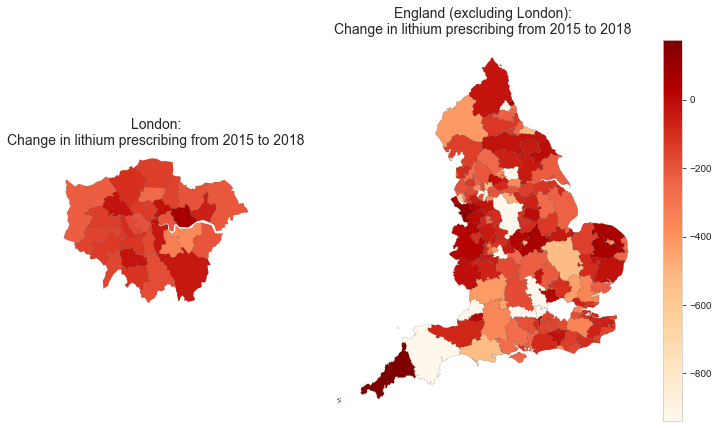

In [44]:
plt.figure(figsize=(12, 7))
plt = maps.ccg_map(df_lithium3, title="Change in lithium prescribing from 2015 to 2018", column='change', separate_london=True)
plt.show()

### Show example of monthly items of lithium from hospital FP10s to check if bias caused by significant secondary care prescribing.  Jan 2019 chosen as example.

In [45]:
sql4 = """
SELECT 
month, 
bnf_code, 
trust_code, 
trust_name, 
items 

FROM ebmdatalab.hscic.prescribing_hospital_community_201901

WHERE (bnf_code LIKE '0402030K0%' OR bnf_code LIKE '0402030P0%')

GROUP BY
month,
bnf_code,
trust_code,
trust_name,
items

ORDER BY
month

"""

df_hospJan19_lithium = bq.cached_read(sql4, csv_path = 'hospJan19_lithium.csv')

In [46]:
df_hospJan19_lithium.head(20)

,month,bnf_code,trust_code,trust_name,items
0,201901,0402030K0AAACAC,RRK00,UNIV HPL B/HAM NHS FOUNDATION TRUST,1.0
1,201901,0402030K0AAACAC,RT500,LEICESTERSHIRE PARTNERSHIP NHS TRUST,1.0
2,201901,0402030K0AAACAC,RHA00,NOTTINGHAMSHIRE HEALTHCARE NHS F TRUST,1.0
3,201901,0402030K0AAACAC,RRE00,MIDLANDS P/SHIP NHS FOUNDATION TRUST,1.0
4,201901,0402030K0AAACAC,RRQ00,CAMDEN & ISLINGTON NHS FOUNDATION TRUST,1.0
5,201901,0402030K0AAACAC,RWK00,EAST LONDON NHS FOUNDATION TRUST,1.0
6,201901,0402030K0AAACAC,RT200,PENNINE CARE NHS FOUNDATION TRUST,2.0
7,201901,0402030K0AAACAC,RXT00,B'HAM & S'HULL MH NHS FOUNDATION TRUST,1.0
8,201901,0402030K0AAACAC,RXV00,GREATER MANCHESTER MENTAL HEALTH NHS FT,1.0
9,201901,0402030K0AAAFAF,R1L00,ESSEX PARTNERSHIP UNIVERSITY NHS FT,1.0


In [47]:
df_hospJan19_lithium['items'].sum()#This shows the total number of items dispensed for all trusts in Jan 2019

934.0

In [48]:
df_hospJan19_lithium.nunique()#This shows that the data represents prescriptions from 56 different trusts in Jan 2019

month          1
bnf_code      12
trust_code    56
trust_name    56
items         12
dtype: int64

In [ ]:
#Compare this against GP data for Jan 19 from df_lithium dataset above
df_lithium['month'] >= "2011-01-01"

### Extract data from QOF to show no. of lithium patients per CCG as determined by QOF denominators for lithium measures.

In [49]:
sql5 = """
SELECT 
year, 
practice_id, 
indicator, 
denominator, 
exceptions

FROM `ebmdatalab.qof.achievement` 

WHERE indicator = 'MH010' #The % of pts on lithium with a record of lithium levels in the therapeutic range in the preceding 4 months

GROUP BY
year, 
practice_id,
indicator,
denominator,
exceptions

ORDER BY
year

"""

df_qof = bq.cached_read(sql5, csv_path='df_qof.csv')

In [50]:
df_qof.head()

,year,practice_id,indicator,denominator,exceptions
0,1516,E82613,MH010,0,NaN
1,1516,J82199,MH010,0,NaN
2,1516,Y04942,MH010,0,NaN
3,1516,Y05167,MH010,0,NaN
4,1516,E82630,MH010,1,NaN


In [51]:
#Where exception is recorded a NaN, need to convert this figure to 0.
df_qof1 = df_qof.fillna(0)
df_qof1.head()

,year,practice_id,indicator,denominator,exceptions
0,1516,E82613,MH010,0,0.0
1,1516,J82199,MH010,0,0.0
2,1516,Y04942,MH010,0,0.0
3,1516,Y05167,MH010,0,0.0
4,1516,E82630,MH010,1,0.0


In [52]:
df_qof1['totalpts'] = (df_qof1['denominator'] + df_qof1['exceptions'])
df_qof1.head()

,year,practice_id,indicator,denominator,exceptions,totalpts
0,1516,E82613,MH010,0,0.0,0.0
1,1516,J82199,MH010,0,0.0,0.0
2,1516,Y04942,MH010,0,0.0,0.0
3,1516,Y05167,MH010,0,0.0,0.0
4,1516,E82630,MH010,1,0.0,1.0


In [53]:
df_qof1.groupby('year').sum()

,denominator,exceptions,totalpts
year,,,
1516,43615,4568.0,48183.0
1617,42492,4343.0,46835.0
1718,41248,4228.0,45476.0
1819,40530,4138.0,44668.0


In [54]:
# Generate graph showing change in QOF patient numbers over time 
plot1 = df_qof.groupby("year")['totalpts'].sum().plot(kind='bar', title="Total number of lithium patients recorded by QOF")
plt.ylim(20000, 50000)

KeyError: 'Column not found: totalpts'

### Compare 2018/9 QOF data (no of lithium patients per practice) with Monthly Practice level data (no of lithium items dispensed per practice)

In [ ]:
#First convert monthly practice level data into annual figures
## Apr2018-Mar2019 data
mask8 = (df_lithium['month'] >= "2018-04-01") & (df_lithium['month'] <= "2019-03-01")
df_annual1819 = df_lithium.loc[mask8]
df_annual1819.head()

In [ ]:
#Next refine QOF data to only include 1819 figures
df_qof1819 = df_qof.loc[df_qof["year"] == "1819"]
df_qof1819.head()

### Describe the no of DDDs or average quantity in each lithium item.  Has this changed over time?